In [1]:
import torch
from torch import nn
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import io

C:\Users\Grace Ng\anaconda3\envs\py3.8\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# downloading sample images
import requests
import shutil 
import mmcv, matplotlib.pyplot as plt

def download_image(image_url,filename):
    r = requests.get(image_url, stream = True)
    if r.status_code == 200:
        r.raw.decode_content = True
        with open(filename,'wb') as f:
            shutil.copyfileobj(r.raw, f)
        print('Image sucessfully Downloaded: ',filename)
        img = mmcv.imread(filename)
        plt.imshow(mmcv.bgr2rgb(img))
        plt.show()
        return True
    else:
        print('Image Couldn\'t be retreived')
        return False

Image Couldn't be retreived
Image sucessfully Downloaded:  ApplePie.jpg


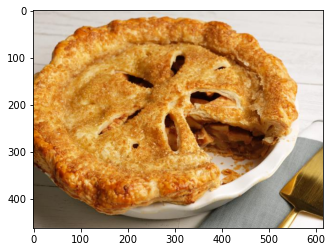

Image sucessfully Downloaded:  Salad.jpg


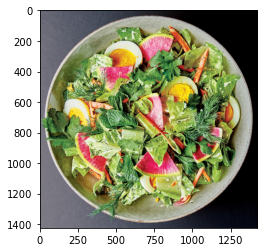

Image sucessfully Downloaded:  Mr-Coconut.jpg


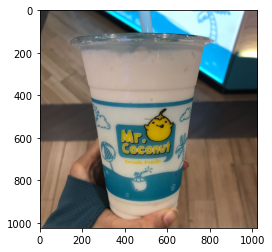

Image sucessfully Downloaded:  Cheesecake.jpg


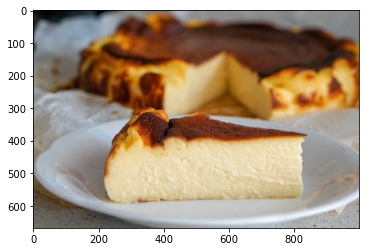

Image sucessfully Downloaded:  BakChorMee.jpg


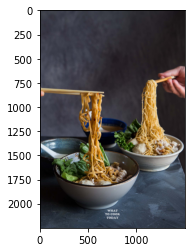

True

In [3]:
download_image(
    "https://m.buro247.sg/images/lifestyle/mcspicy-mcds-cra.jpg",
    "McSpicy.jpg"
)
download_image(
    "https://food.fnr.sndimg.com/content/dam/images/food/fullset/2019/7/11/0/FNK_the-best-apple-pie_H_s4x3.jpg.rend.hgtvcom.616.462.suffix/1562853900284.jpeg",
    "ApplePie.jpg"
)
download_image(
    "https://assets.bonappetit.com/photos/5e8cdb60a7a01c00083b08a9/1:1/w_2560%2Cc_limit/HMONG-Potluck-Chopped-Salad.jpg",
    "Salad.jpg"
)
download_image(
    "https://images.happycow.net/venues/1024/11/33/hcmp113353_367000.jpeg",
    "Mr-Coconut.jpg"
)
download_image(
    "https://spanishsabores.com/wp-content/uploads/2020/05/DSC08145.jpg",
    "Cheesecake.jpg"
)
download_image(
    "https://whattocooktoday.com/wp-content/uploads/2016/08/IMG_0414.jpg",
    "BakChorMee.jpg"
)

In [2]:
# upload model file here
model = models.mobilenet_v2(pretrained=True)
num_ftrs = model.classifier[1].in_features
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.classifier[1] = nn.Linear(num_ftrs, 101)
device = torch.device("cpu")
model = model.to(device)
model.load_state_dict(torch.load('food_model.pt', map_location=device))


<All keys matched successfully>

In [3]:
print(model)

MobileNetV2(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05,

In [4]:
with open('classes.txt') as f:
   classes = f.read().splitlines()
print(classes)

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheesecake', 'cheese_plate', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_sou

In [5]:
# we modify the default inference function so that we get the top n results
def inference_model(model, img, num):
    """Inference image(s) with the classifier.
    Args:
        model (nn.Module): The loaded classifier.
        img (str/ndarray): The image filename or loaded image.
    Returns:
        result (dict): The classification results that contains
            `class_name`, `pred_label` and `pred_score`.
    """
    image_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    img = Image.open(io.BytesIO(img))
    input = image_transforms(img)
    input = input.unsqueeze(0)
    # forward the model
    with torch.no_grad():
        model.eval()
        scores = model(input)
        scores = torch.nn.functional.softmax(scores, dim=1)
        results = []
        for i in range(num):
            pred_score = torch.max(scores)
            pred_label = torch.argmax(scores).item()
            result = {'pred_label': pred_label, 'pred_score': float(pred_score)}
            result['pred_class'] = classes[result['pred_label']]
            results.append(result)
            scores[0][pred_label] = -999999
    return [input, results]

In [6]:
def show_results(model, img, num=5):
    input, result = inference_model(model,img, num)
    print(result)
    plt.imshow(input[0].permute(1,2,0))

In [7]:
show_results(model,'images.jpg', 5)

TypeError: a bytes-like object is required, not 'str'